<a href="https://en.wikipedia.org/wiki/Auk%C5%A1taitija" target="_blank"><img src="https://upload.wikimedia.org/wikipedia/lt/1/18/Aukstaitijosherbas.PNG" alt="IMAGE ALT TEXT HERE" width="480" border="10"/></a>

--------------------
austechia is a Jupyter notebook that provides some example code of how to plot trees imported with baltic.

------------

Copyright 2016 [Gytis Dudas](https://twitter.com/evogytis). Licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

## The classes of baltic
------------

There are 3 main classes in baltic:
- node = internal branches
- leaf = external branches
- tree = the entirety of the tree

The node and leaf classes are similar and share many parameters in common, such as branch length, height, position in absolute time, traits, parents, x and y coordinates and index of the character which defined them in the tree string. They differ in that the node class contains a list of its children objects for tree traversals, called children and a list of all tips that descend from it eventually, called leaves. Node class also contains parameters like childHeight and numChildren which are less important. The leaf class contains two name variables: numName and name. numName corresponds to whatever was used to designate the tip in the tree string. name can be set later and is meant to handle scenarios where the tree string contains tip names encoded as numbers (Nexus format), which can be decoded into name, rather than overwriting whatever was caught in numName.

The tree class wraps leaf and node classes together by performing operations to build, manipulate, visualise and analyse the full tree data structure. The recommended way of interacting with the tree is via the Objects list, which is a flat list of all branches in the tree.

baltic now also has a clade class. They are introduced when a subtree is collapsed and pose as tips for tree traversals.

## The function
------------

At the top is the make_tree function. Given a valid tree string and an empty tree object it will transform the information contained in the tree string into an actual tree data structure. If there are elements within the tree string that it can't parse it will warn the user of this. The most common reasons for this are unexpected characters in branch labels or something unexpected in tip names.

In [1]:
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')

## Tree import
-----------
I haven't dedicated much time to writing a general tree parser to handle all cases, but the example below shows how to handle a simple FigTree file. Similar code can now be called by baltic's loadNexus() function, which takes a path to a tree file in nexus format and returns a baltic tree object. If other formats are required, such as newick, it should be as easy as handing the make_tree function the tree string and an empty tree object.

In [2]:
from IPython.display import HTML
import re
import copy

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
from scipy.special import binom

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def Bernstein(n, k):
    """Bernstein polynomial.
    """
    coeff = binom(n, k)

    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)

    return _bpoly

def Bezier(points,start,end,num=10):
    """Build Bézier curve from points.
    """
    N = len(points)
    t = np.linspace(start, end, num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
        
    return curve

def Bezier_control(pointA,pointB,height):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance that defines a line perpendicular to line AB which intercepts AB at its midpoint.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB
    
    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2)
        
    h=np.sqrt(height**2+(d**2)/4.0)
    
    n1=x1+h*np.cos(np.arctan(2*height/float(d))+np.arctan(slope))*sign
    n2=y1+h*np.sin(np.arctan(2*height/float(d))+np.arctan(slope))*sign

    return (n1,n2)

tree_path='/Users/evogytis/Documents/fluB/data/mcc trees/InfB_NPt_ALLs1.mcc.tre' ## define path to (in this case) FigTree file
print "File: %s"%(tree_path.split('/')[-1])
tipFlag=False ## used to keep track of where we are in FigTree format
tips={} ## dictionary of tip code to full tip name

for line in open(tree_path,'r'): ## iterate through FigTree lines
    l=line.strip('\n') ## strip newline characters from each line

    cerberus=re.search('dimensions ntax=([0-9]+);',l.lower()) ## check how many tips there are supposed to be
    if cerberus is not None:
        tipNum=int(cerberus.group(1))

    #####################
    cerberus=re.search('tree TREE([0-9]+) = \[&R\]',l) ## search for beginning of tree string in BEAST format
    if cerberus is not None:
        treeString_start=l.index('(') ## tree string starts where the first '(' is in the line
        ll=bt.tree() ## new instance of tree
        bt.make_tree(l[treeString_start:],ll) ## send tree string to make_tree function, provide an empty tree object
    #####################
        
    if tipFlag==True:
        cerberus=re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',l) ## look for tip name map, where each tip is given an integer to represent it in tree
        if cerberus is not None:
            tips[cerberus.group(1)]=cerberus.group(2).strip("'") ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in l: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',l.replace('\t','')

    if 'translate' in l.lower(): ## start looking for tips
        tipFlag=True
    if ';' in l: ## stop looking for tips
        tipFlag=False

print "Number of objects found in tree string: %d"%(len(ll.Objects))

## rename tips, find the highest tip (in absolute time) in the tree
if len(tips)==0: ## use this if tip names in the string are already the final format
    for k in ll.Objects:
        if isinstance(k,leaf):
            k.name=k.numName
    highestTip=max([bt.decimalDate(x.name.strip("'").split('_')[-1],variable=True) for x in ll.Objects if isinstance(x,leaf)])
else: ## there's a tip name map at the beginning, so translate the names
    ll.renameTips(tips) ## give each tip a name
    highestTip=max([bt.decimalDate(x.strip("'").split('_')[-1],variable=True) for x in tips.values()])

ll.treeStats() ## report tree stats (also traverses tree), otherwise need to call ll.traverse_tree()
ll.sortBranches() ## sort the branches, automatically draws tree, otherwise need to call ll.drawTree()

## set absolute time knowing *when* the most recent tip is in absolute time
ll.setAbsoluteTime(highestTip)
print 'Highest tip date: %.4f'%(highestTip)

path='<iframe style="border: 0; width: 400px; height: 345px;" src="https://bandcamp.com/EmbeddedPlayer/album=2074815275/size=large/bgcol=ffffff/linkcol=333333/artwork=small/track=42188979/transparent=true/" seamless><a href="http://obsrr.bandcamp.com/album/nustebusiam-neb-ti">NUSTEBUSIAM NEBUTI by OBSRR</a></iframe>'

print 'Done!'
HTML(path)

File: InfB_NPt_ALLs1.mcc.tre
Number of objects found in tree string: 903

Tree height: 29.430115
Tree length: 451.887106

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)

Highest tip date: 2012.1530
Done!


## Plotting trees
-----------
As long as the drawTree() function has been called from the tree object it's possible to draw out the tree by iterating over every branch in the tree object and plotting it. It remains up to the user as to how the tree gets plotted in terms of colour, branch width, tip sizes, tip labels, etc.

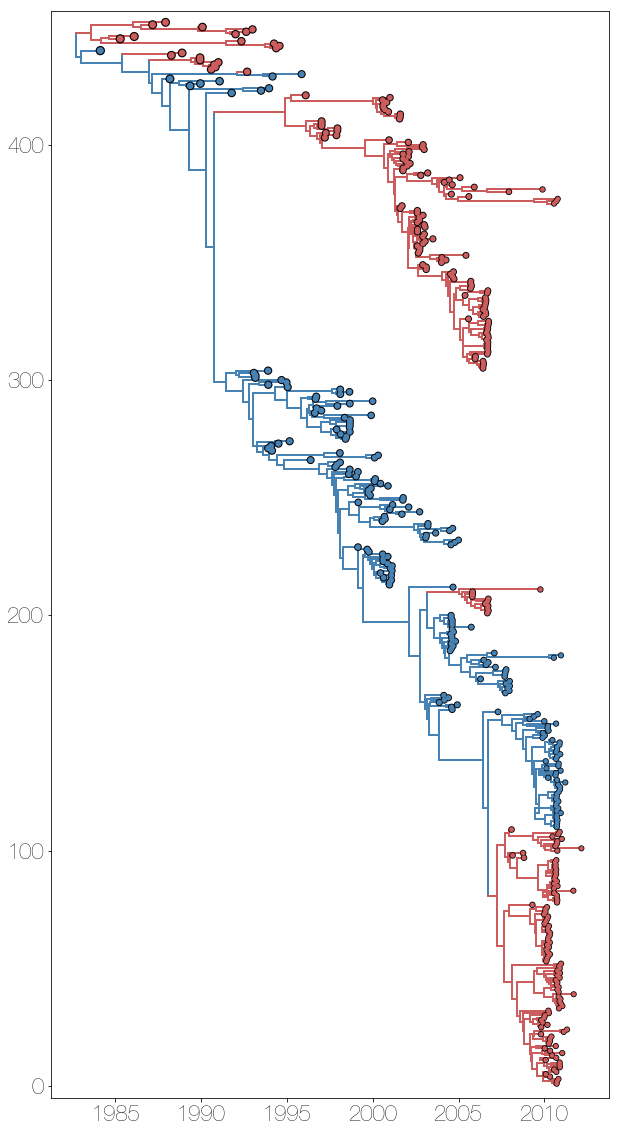

In [3]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis

for k in ll.Objects: ## iterate over objects in tree
#     x=k.x ## or from x position determined earlier
    x=k.absoluteTime ## or use absolute time instead
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
#     xp=k.parent.x ## get x position of current object's parent
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

#     c='indianred' ## colour can be fixed
#     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
#     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
    c=['indianred' if k.traits['PB1']=='V' else 'steelblue'][0] ## can be discrete too
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
        
        s=50 ## tip size can be fixed
        s=50-30*k.height/ll.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
ax.set_ylim(-5,ll.ySpan+5)
plt.show()

## Collapsing branches
------
Branches can be collapsed based on trait values or attribute values that don't satisfy a function. The returned tree object then needs to be redrawn using the drawTree() method to get new y positions for branches.

903 644


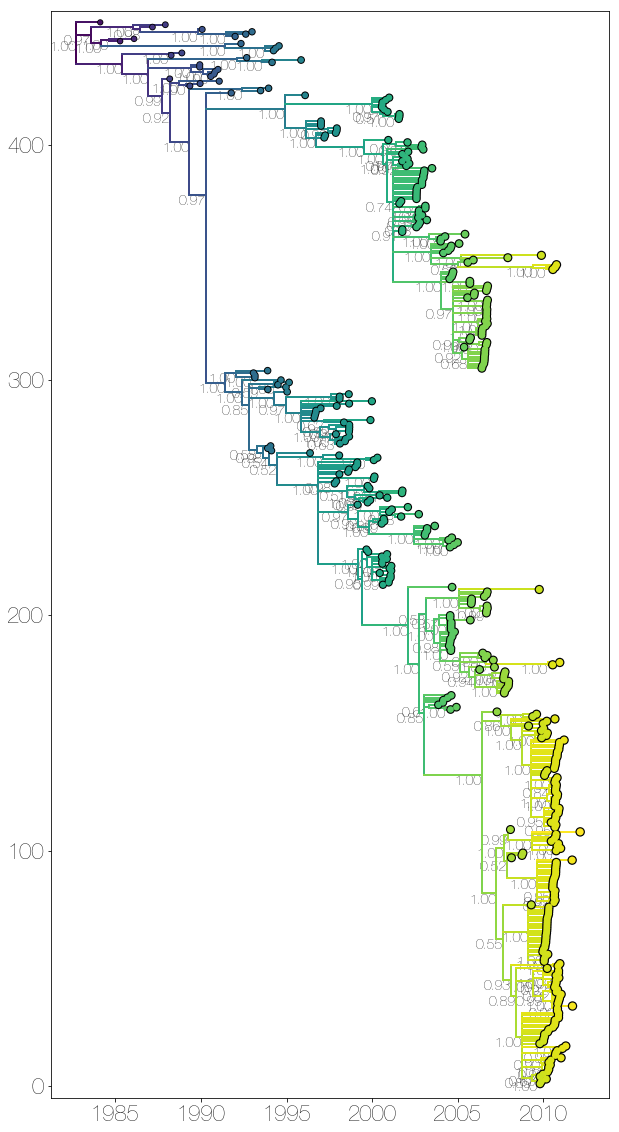

In [4]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis

cc=ll.collapseBranches('posterior',lambda x:x<=0.5) ## collapse branches below 0.5 posterior probability
# cc=ll.collapseBranches('index',lambda x:x>1000000) ## collapse branches whose index in tree string are above 1 million
cc.sortBranches() ## sort branches, also redraws tree

print len(ll.Objects),len(cc.Objects) ## check how many branches were collapsed

for k in cc.Objects: ## iterate over objects in tree
#     x=k.x ## or from x position determined earlier
    x=k.absoluteTime ## absolute time on the x, rather than height
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
#     xp=k.parent.x ## get x position of current object's parent
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    c=cmap(k.height/ll.treeHeight) ## or be a function of something else
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=50 ## tip size can be fixed
        s=20+30*k.height/ll.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot vertical bar
        ax.text(x,y,'%.2f'%(k.traits['posterior']),va='top',ha='right',size=14) ## plot posterior values at each node

    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot actual branch (horizontal)
        
ax.set_ylim(-5,cc.ySpan+5)
plt.show()

## Extract trait subtrees, fix subtrees
-------
The following cell showcases code to decompose trees with trait labels into individual subtrees, which are recovered from within-trait tree traversals. Occasionally it means ending up with nodes with only one valid child, which needs to be fixed.

In [5]:
traitName='PB1'
branchWidth=2
tipSize=30

ll.root.traits[traitName]='ancestor' ## add fake trait to root of the tree

tree_strings={'Y':[],'V':[],'ancestor':[]}
subtype_trees={'Y':[],'V':[],'ancestor':[]}

for l in ll.Objects:
    k=l
    kp=l.parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName):
        kploc=kp.traits[traitName]
        kpc=kploc
    else:
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc
    
    ## if states do not match
    if kc!=kpc:
        proceed=False
          
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if dealing with a leaf - proceed
            N_children=1
            proceed=True
        else:
            N_children=len(k.leaves)
            if [ch.traits[traitName] for ch in k.children].count(kc)>=1: ## check if at least 1 child of a node is in the same state - proceed only if they are
                proceed=True
                
            print 'Both children within the same trait: %s (%s)'%(proceed,','.join([ch.traits[traitName] for ch in k.children]))

        if proceed==True:
            subtree=ll.subtree(k,traitName=traitName) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the trait value state of k
            
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[kc].append((kpc,subtree))
            
print 'Done!'

Both children within the same trait: True (V,Y)
Both children within the same trait: True (V,V)
Both children within the same trait: True (V,V)
Both children within the same trait: True (V,V)
Both children within the same trait: True (V,V)
Both children within the same trait: True (V,V)
Both children within the same trait: True (V,V)
Done!


## Tree spectrum
--------
This next bit plots every extracted subtree onto a single plot.

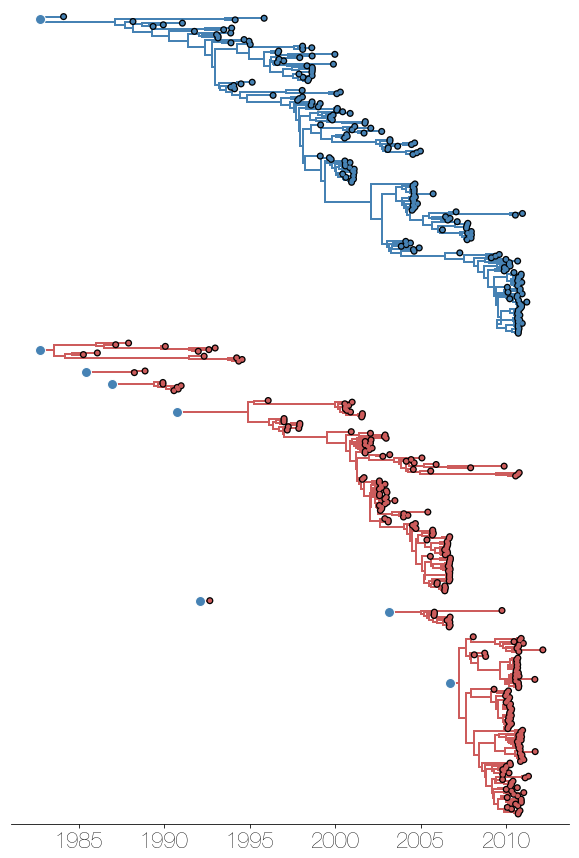

In [6]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')

traitName='PB1'
branchWidth=2
tipSize=20

cumulative_y=0
for subtype in ['V','Y']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        if len([ob for ob in loc_tree.Objects if isinstance(ob,bt.leaf)])>0: ## proceed only if there's at least one tip in subtree
            for w in loc_tree.Objects: ## iterate over subtree
                c=['indianred' if w.traits[traitName]=='V' else 'steelblue'][0] ## get colour

                y=w.y
                x=w.absoluteTime

                if y!=None:

                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y

                    if isinstance(w,bt.leaf): ## if leaf - plot tip circle
                        ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                        ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

                    elif isinstance(w,bt.node): ## if node - plot vertical bar
                        yl=w.children[0].y
                        yr=w.children[-1].y
                        
                        ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                        
                    ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot branch
                    
                    

            oriC=['indianred' if origin=='V' else 'steelblue'][0]
            if loc_tree.Objects[0].absoluteTime==None:
                oriX=loc_tree.Objects[0].absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y
            else:
                oriX=loc_tree.Objects[0].parent.absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y

            ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin

            cumulative_y+=max([x.y for x in loc_tree.Objects])+5 ## increment y displacement

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)

plt.show()

## Turning a tree data structure into a string

baltic can convert the data structure contained within the tree class to a tree string, with options to include the numName or the name attribute for tips and the inclusion of BEAST annotations.

In [7]:
traitCombos=[['posterior'],[],['PB1','PB2','HA','PB1.set'],['length','length_95%_HPD'],['height','height_95%_HPD']]
numNames=[True,False,True,False,True]

for subtree,traitCombo,outputWithNumber in zip(subtype_trees['V'],traitCombos,numNames):
    origin,sbtr=subtree
    
    sbtr.singleType() ## within-trait traversal may result in multitype trees - many software won't take those, so we're turning each subtree into a singletype tree
    
    print 'Number of objects in subtree: %d, annotations to include: %s, use number encoding for tips: %s'%(len(sbtr.Objects),traitCombo,outputWithNumber)

    print '\n#NEXUS\nBegin trees;\ntree TREE1 = [&R] %s\nEnd;\n\n'%(sbtr.toString(traits=traitCombo,numName=outputWithNumber))

Number of objects in subtree: 11, annotations to include: ['posterior'], use number encoding for tips: True

#NEXUS
Begin trees;
tree TREE1 = [&R] ('16':0.519606,('15':0.292285,('84':0.896462,('285':0.332987,('150':0.313269,'425':0.065022)[&posterior=0.28885679369]:0.081792)[&posterior=1.0]:0.330872)[&posterior=1.0]:0.458146)[&posterior=0.221308743473]:0.230951)[&posterior=1.0]:2.477703;
End;


Number of objects in subtree: 1, annotations to include: [], use number encoding for tips: False

#NEXUS
Begin trees;
tree TREE1 = [&R] 'B/Hong_Kong/02/1993_1993-02-15':0.578402;
End;


Number of objects in subtree: 217, annotations to include: ['PB1', 'PB2', 'HA', 'PB1.set'], use number encoding for tips: True

#NEXUS
Begin trees;
tree TREE1 = [&R] ((('38'[&PB1="V",PB2="V",HA="V",PB1.set={"V"}]:0.150592,(('29'[&PB1="V",PB2="V",HA="V",PB1.set={"V"}]:0.236266,'327'[&PB1="V",PB2="V",HA="V",PB1.set={"V"}]:0.159606)[&PB1="V",PB2="V",HA="V",PB1.set={"V"}]:1.317788,('44'[&PB1="V",PB2="V",HA="V",PB1.se

## Tree transformations
------
This next bit plots the tree in terms of the trait transitions that take place within it. Trait space is where things get plotted, but other dimensions, such as time, can be represented with colour or line width, as desired. I've also added code to do Bezier curves, which I think are an amazing tool in a scientist's arsenal, mostly because they can be customised to prevent overlapping with each other and to highlight links between closely positioned points.

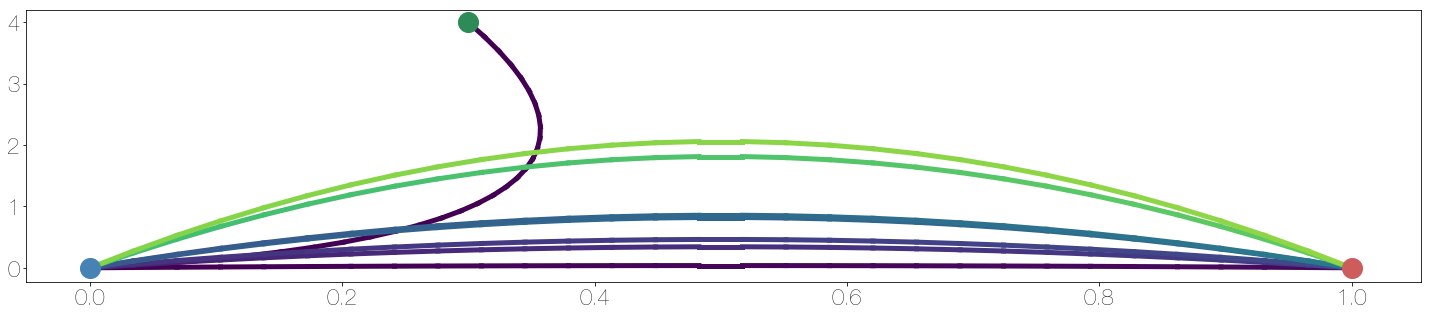

In [8]:
fig,ax = plt.subplots(figsize=(25,5),facecolor='w')

cmap=mpl.cm.viridis
coords={'V':(1,0),'Y':(0,0),'ancestor':(0.3,4)} ## coordinates for trait values

## plot traits as points
ax.scatter(coords['V'][0],coords['V'][1],s=400,facecolor='indianred',zorder=99999999)
ax.scatter(coords['Y'][0],coords['Y'][1],s=400,facecolor='steelblue',zorder=99999999)
ax.scatter(coords['ancestor'][0],coords['ancestor'][1],s=400,facecolor='seagreen',zorder=99999999)

for k in ll.Objects: ## iterate over objects in tree
    ct=k.traits[traitName] ## fetch current and parent traits
    pt=k.parent.traits[traitName]
    if ct!=pt: ## if they don't match - a switch happened
        
        P1=coords[pt] ## fetch coordinates of points
        P2=coords[ct]
        
        begin=k.parent.height ## fetch heights of node and its parent
        end=k.height
        
        mid_frac=(end+begin)/2.0/ll.treeHeight ## calculate the fractional height of middle of transitioning branch in tree
        
        if pt!='ancestor':
            control=Bezier_control(P1,P2,mid_frac*5) ## if dealing with a regular transition - control point is positioned according to fractional height of transition
        else:
            control=(0.5,0.5) ## if dealing with transition from ancestral state to regular states position control point in the middle
        curve=Bezier([P1,control,P2],0.0,1.0,num=30) ## get Bezier curve coordinates
        
        for f in range(len(curve)-1): ## iterate over segments of the line
            x1,y1=curve[f]
            x2,y2=curve[f+1]
            frac=f/float(len(curve)) 

            ax.plot([x1,x2],[y1,y2],lw=5,color=cmap((begin+(end-begin)*frac)/ll.treeHeight),zorder=int(mid_frac*10000)) ## plot each segment individually, colouring according to what fraction of the tree the segment traversed in time

plt.show()

## Tangled chains (sequential tanglegrams)
-------
The following code imports a bunch of trees, collapses nodes, plots them end to end coloured by the trait value of the first tree and connects the same tips by lines that follow the order of tips in the first tree.

In [9]:
tree_base='/Users/evogytis/Documents/fluB/data/mcc trees/'

tree_paths=['InfB_PB1t_ALLs1.mcc.tre','InfB_PB2t_ALLs1.mcc.tre',
            'InfB_PAt_ALLs1.mcc.tre','InfB_HAt_ALLs1.mcc.tre',
            'InfB_NPt_ALLs1.mcc.tre','InfB_NAt_ALLs1.mcc.tre',
            'InfB_M1t_ALLs1.mcc.tre','InfB_NS1t_ALLs1.mcc.tre'] ## define a whole list of tree files

trees={} ## dict 

for tree_path in tree_paths: ## iterate over tree files
    print "File: %s"%(tree_path)
    tipFlag=False ## used to keep track of where we are in FigTree format
    tips={} ## dictionary of tip code to full tip name
    ll=bt.loadNexus(tree_base+tree_path,tip_regex="\_([0-9]+)\-([0-9]+)\-([0-9]+)",variableDate=True) ## loading a tree by specifying a path, a custom tip date regex string and that dates are sometimes incomplete
    
    trees[tree_path.split('_')[1]]=ll ## add tree object to dict

    print 'Done!'

File: InfB_PB1t_ALLs1.mcc.tre

Tree height: 28.071359
Tree length: 481.049928

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)

Done!
File: InfB_PB2t_ALLs1.mcc.tre

Tree height: 30.210110
Tree length: 484.851289

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)

Done!
File: InfB_PAt_ALLs1.mcc.tre

Tree height: 29.500153
Tree length: 458.766950

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)

Done!
File: InfB_HAt_ALLs1.mcc.tre

Tree height: 30.415856
Tree length: 449.376345

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)

Done!
File: InfB_NPt_ALLs1.mcc.tre

Tree height: 29.430115
T

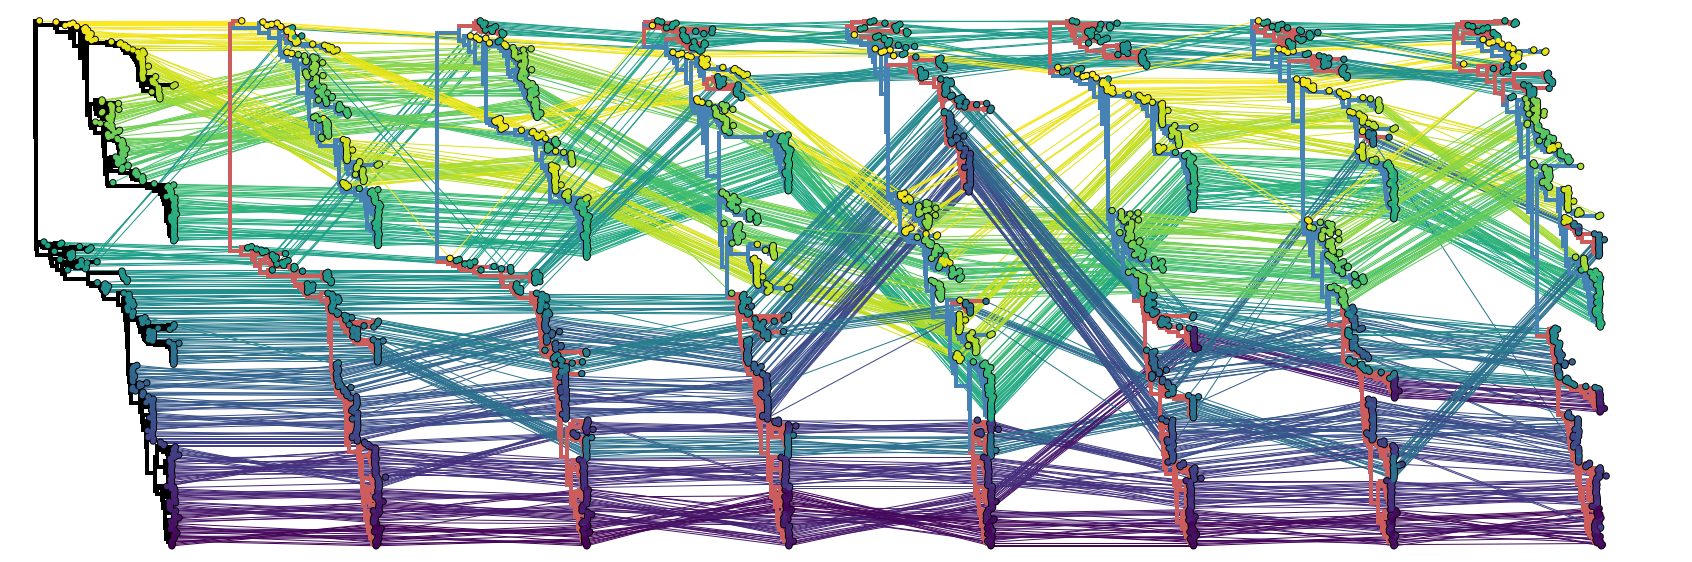

In [10]:
fig,ax = plt.subplots(figsize=(30,10),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by
cmap=mpl.cm.viridis
cumulative_displace=0 ## this tracks the "current" x position, so trees are plotted one after another

branchWidth=4 ## increase branch width, since trees will be smaller

tree_names=['PB1t','PB2t','HAt','PAt','NPt','NAt','M1t','NS1t'] ## define order in which dict will be accessed

tip_positions={x:{} for x in tree_names} ## remember the position of each tip in each tree

for tr in tree_names: ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    for k in cur_tree.Objects: ## iterate over branches
        if isinstance(k,bt.leaf): ## only interested in leaves
            tip_positions[tr][k.name]=(k.height,k.y) ## remember tree, tip's position

for t,tr in enumerate(tree_names): ## iterate over trees
    cur_tree=trees[tr] ## fetch tree object
    
    for k in cur_tree.Objects: ## iterate over branches
    #     x=k.x ## or from x position determined earlier
        x=k.height ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

    #     xp=k.parent.x ## get x position of current object's parent
        xp=k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
    
        x+=cumulative_displace ## adjust branch position by displacement, which depends on the position of tree in the overall plot
        xp+=cumulative_displace ## same for branch's parent
    #     c='indianred' ## colour can be fixed
    #     c=cmap(k.height/ll.treeHeight) ## or be a function of something else
    #     c=[cmap(k.traits['posterior']) if k.traits.has_key('posterior') else cmap(1.0)][0]
        if k.traits.has_key(traitName):
            c=['indianred' if k.traits[traitName]=='V' else 'steelblue'][0] ## can be discrete too
        else:
            c='k'
        if isinstance(k,bt.leaf): ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name

            s=30 ## tip size can be fixed
            
            pos_in_first_tree=tip_positions['PB1t'][k.name][1] ## fetch y coordinate of same tip in the first tree
            frac_pos=pos_in_first_tree/float(len(cur_tree.Objects))*2.0 ## normalize coordinate to be within interval [0.0,1.0]
            
            ax.scatter(x,y,s=s,facecolor=cmap(frac_pos),edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            if t!=len(tree_names)-1: ## as long as we're not at the last tree - connect tips with coloured lines
                next_x,next_y=tip_positions[tree_names[t+1]][k.name] ## fetch coordinates of same tip in next tree
                next_x+=cumulative_displace+cur_tree.treeHeight+10 ## adjust x coordinate by current displacement and future displacement
                
                ax.plot([x,next_x],[y,next_y],lw=1,ls='-',color=cmap(frac_pos),zorder=0) ## connect current tip with same tip in the next tree
            
        elif isinstance(k,bt.node): ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) ## plot vertical bar

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9) ## always plot branch
        
    cumulative_displace+=cur_tree.treeHeight+10 ## increment displacement by the height of the tree

ax.set_ylim(-5,len([x for x in cur_tree.Objects if isinstance(x,bt.leaf)])+10) ## set y limits
ax.set_xlim(-5,cumulative_displace+5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

## Radial trees and shutter plots
-----
The cell below shows code that can be used to plot radial trees, in addition to code that could be used to plot a series of trees in a circle facing inwards with a particular isolate highlighted in all plotted phylogenies. This was a suggestion proposed by Anne-Mieke Vandamme at the amazing Virus Genomics and Evolution (#VGE16) meeting in Cambridge in June 2016.

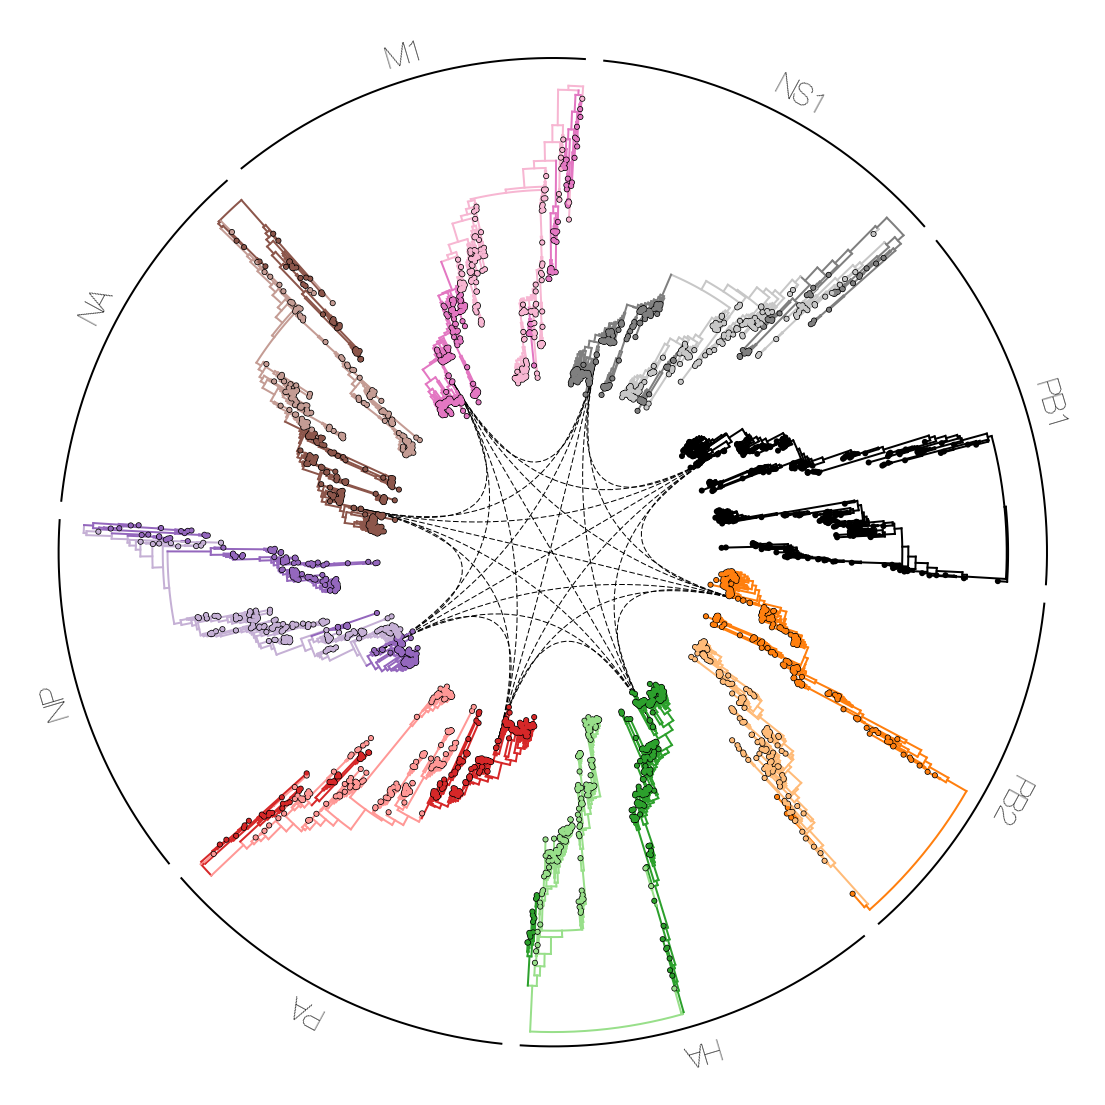

In [11]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by

branchWidth=2 ## default branch width

# inwardSpace=-1.15 ## determines how much space is left in the middle, if negative (and >1) trees are plotted pointing outwards
inwardSpace=0.5
gap=0.95 ## determines how much of their allocated space along the circle a tree uses

tree_names=['PB1t','PB2t','HAt','PAt','NPt','NAt','M1t','NS1t'] ## define order in which dict will be accessed
# tree_names=['PB1t','PB2t','HAt','PAt','NPt'] ## define order that makes a pentagram
# tree_names=['PB1t','PB2t','HAt'] ## define order that plots coevolving segments
# tree_names=['PB1t','HAt'] ## define order that plots two trees

cmap=mpl.cm.Vega20 ## choose a colour map
vega_colours={tree:[cmap((t*2)/20.0),cmap((t*2+1)/20.0)] for t,tree in enumerate(tree_names)}

circFrac=1/float(len(tree_names)) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle

all_tips=[r.name for r in trees['PB1t'].Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip

foci=[all_tips[randomTip]] ## set it as focus - any tips listed here will be connected in a tanglegram-y way

controlDepth=max([trees[treeName].treeHeight for treeName in tree_names]) ## find the height of the highest tree

for t,tr in enumerate(tree_names): ## iterate over trees
    baseCircle=2*np.pi*startFrom ## tree starts here along the circle
    
    cur_tree=trees[tr] ## fetch tree

    leaves=[w.name for w in cur_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
    leafCount=len(leaves) ## count leaves in the tree
    mostRecent=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip
    
    if inwardSpace<0.0:
        labelX=-abs(inwardSpace)*1.05
    else:
        labelX=inwardSpace+1.05
    labelY=baseCircle+circFrac*np.pi
    
    ax.text(np.sin(labelY)*labelX*1.05,np.cos(labelY)*labelX*1.05,'%s'%(tr[:-1]),size=30,rotation=-np.rad2deg(labelY),va='center',ha='center')
    
    treeBar=np.linspace(baseCircle,baseCircle+2*gap*circFrac*np.pi,40)
    ax.plot(np.sin(treeBar)*labelX,np.cos(treeBar)*labelX,lw=2,ls='-',color='k')
    
    for k in cur_tree.Objects: ## iterate through objects in the tree
        y=k.y ## get y position of current object
        x=k.absoluteTime ## get x position of current object
        xp=k.parent.absoluteTime ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        ## once a tree is circular (or radial) the x coordinate is transformed into a coordinate along a circle of a bigger or smaller diameter
        # this is done by starting from the inward space, and plotting things deeper in time outwards
        xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
        xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate

        ## circularisation of the tree depends on transforming y coordinates into positions along a circle
        # this is done by specifying a position that is a fraction along a circle of length 2*pi
        # such coordinates are then plotted using sin(y) and cos(y) to get x and y coordinates along a circle, respectively
        yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate
        
        if k.traits.has_key(traitName): ## if tree has PB1 trait - colour accordingly
            c=[vega_colours[tr][0] if k.traits[traitName]=='V' else vega_colours[tr][1]][0] ## pick from colour pairs
        else: ## otherwise - black
            c='k'
            
        if isinstance(k,bt.leaf): ## if leaf...
            s=20
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip, notice that coordinates that were y coordinates are now transformed with sin and cos and previous x coordinate is used to scale the circle up
            ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            if k.name in foci: ## if tip is one of the wanted tips for tanglegram
                p1=(np.sin(yc)*xc , np.cos(yc)*xc) ## get actual plot coordinates of origin tip along circle for a tanglegram connection
                
                startFrom2=startFrom ## start circle positioning based on current position
                for nex in range(t,len(tree_names)): ## iterate over other trees
                    if nex>t: ## only start at the next tree
                        nex_tree=trees[tree_names[nex]] ## fetch next tree
                        baseCircle2=2*np.pi*startFrom2
                        leaves2=[w.name for w in nex_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the next tree
                        leafCount2=len(leaves2) ## count leaves in next tree
                        mostRecent2=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip in the next tree
                        
                        for h in nex_tree.Objects: ## iterate through objects in next tree
                            if isinstance(h,bt.leaf) and h.name==k.name: ## if at the same tip...
                                y2=h.y ## get y position
                                x2=h.absoluteTime ## get x position
                                xp2=h.parent.absoluteTime ## get x position of current object's parent

                                if x2==None: ## matplotlib won't plot Nones, like root
                                    x2=0.0
                                if xp2==None:
                                    xp2=x2

                                xc2=inwardSpace+((mostRecent2-x2)/controlDepth) ## transform x coordinate of object in next tree
                                xpc2=inwardSpace+((mostRecent2-xp2)/controlDepth) ## transform x parent's coordinate in next tree
                                yc2=baseCircle2+circFrac*np.pi*2*(y2/float(leafCount2))*gap ## transform y coordinate in next tree

                                p2=(np.sin(yc2)*xc2,np.cos(yc2)*xc2) ## get actual plot coordinate of target tip in next tree

                                bezLine=Bezier([p1,0.0,p2],0.0,1.0,30) ## Bezier curve with control point at (0,0)
                                ax.plot(bezLine[:,0],bezLine[:,1],color='k',ls='--',lw=1) ## plot Bezier curve

                    startFrom2+=circFrac ## increment to next tree
            
        elif isinstance(k,bt.node): ## if node...
            yl=k.children[-1].y ## fetch first child y coordinate
            yr=k.children[0].y ## fetch last child y coordinate

            ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
            ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child

            ybar=np.linspace(ycl,ycr,15) ## create a curved bar

            ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=9) ## plot curved bar at the base of a node

        ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=9) ## plot ancestral branch
    
    startFrom+=circFrac ## increment position along circle for next tree

# ax.set_xlim(-inwardSpace*1.1,inwardSpace*1.1) ## plot limits
# ax.set_ylim(-inwardSpace*1.1,inwardSpace*1.1)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_aspect(1) ## aspect set to 1 for proper circular plot
plt.show()

This cell re-orients the tree such that time now follows the circle.

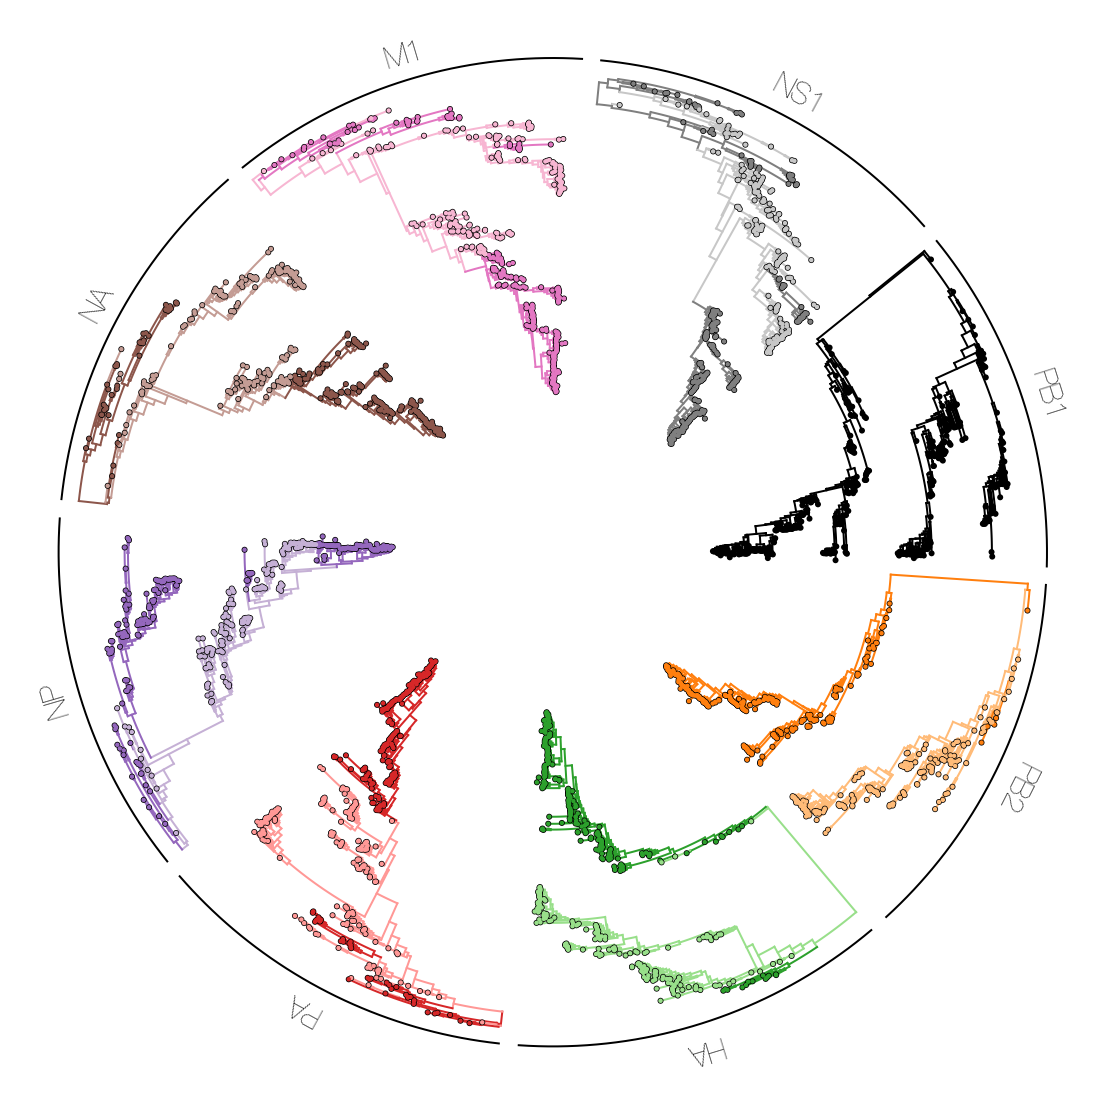

In [12]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='PB1' ## choose a trait to colour branches by

branchWidth=2 ## default branch width

# inwardSpace=-1.15 ## determines how much space is left in the middle, if negative (and >1) trees are plotted radiating outwards
inwardSpace=0.5
gap=0.95 ## determines how much of their allocated space along the circle a tree uses

tree_names=['PB1t','PB2t','HAt','PAt','NPt','NAt','M1t','NS1t'] ## define order in which dict will be accessed
# tree_names=['PB1t','PB2t','HAt','PAt','NPt'] ## define order that makes a pentagram
# tree_names=['PB1t','PB2t','HAt'] ## define order that plots coevolving segments
# tree_names=['PB1t','HAt'] ## define order that plots two trees

cmap=mpl.cm.Vega20 ## choose a colour map
vega_colours={tree:[cmap((t*2)/20.0),cmap((t*2+1)/20.0)] for t,tree in enumerate(tree_names)}

totalCircle=sum([trees[treeName].treeHeight for treeName in tree_names]) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle

all_tips=[r.name for r in trees['PB1t'].Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip

foci=[all_tips[randomTip]] ## set it as focus - any tips listed here will be connected in a tanglegram-y way

controlDepth=len(trees[tree_names[0]].Objects)/2 ## find the height of the highest tree along y axis

for t,tr in enumerate(tree_names): ## iterate over trees
    baseCircle=2*np.pi*startFrom ## tree starts here along the circle
    
    cur_tree=trees[tr] ## fetch tree
    circFrac=cur_tree.treeHeight/totalCircle
    leaves=[w.name for w in cur_tree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
    leafCount=len(leaves) ## count leaves in the tree
    mostRecent=max([bt.decimalDate(n.split('_')[-1],variable=True) for n in leaves]) ## find the most recent tip
    
    if inwardSpace<0.0:
        labelX=-abs(inwardSpace)*1.05
    else:
        labelX=inwardSpace+1.05
    labelY=baseCircle+circFrac*np.pi
    
    ax.text(np.sin(labelY)*labelX*1.05,np.cos(labelY)*labelX*1.05,'%s'%(tr[:-1]),size=30,rotation=-np.rad2deg(labelY),va='center',ha='center')
    
    treeBar=np.linspace(baseCircle,baseCircle+2*gap*circFrac*np.pi,40)
    ax.plot(np.sin(treeBar)*labelX,np.cos(treeBar)*labelX,lw=2,ls='-',color='k')
    
    for k in cur_tree.Objects: ## iterate through objects in the tree
        y=k.y ## get y position of current object
        x=k.absoluteTime ## get x position of current object
        xp=k.parent.absoluteTime ## get x position of current object's parent
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        ## once a tree is circular (or radial) the y coordinate is transformed into a coordinate along a circle of a bigger or smaller diameter
        # this is done by starting from the inward space, and plotting things higher or lower along the circle
        yc=inwardSpace+y/float(leafCount) ## transform y coordinate

        ## circularisation of the tree depends on transforming x coordinates into positions along a circle
        # this is done by specifying a position that is a fraction along a circle of length 2*pi
        # such coordinates are then plotted using sin(x) and cos(x) to get y and x coordinates along a circle, respectively
        xc=baseCircle+circFrac*np.pi*2*(k.height/float(cur_tree.treeHeight))*gap ## transform x coordinate
        xpc=baseCircle+circFrac*np.pi*2*(k.parent.height/float(cur_tree.treeHeight))*gap ## transform x parent's coordinate
        
        xbar=np.linspace(xpc,xc,15)

        if k.traits.has_key(traitName): ## if tree has trait - colour accordingly
            c=[vega_colours[tr][0] if k.traits[traitName]=='V' else vega_colours[tr][1]][0]
        else: ## otherwise - black
            c='k'
            
        if isinstance(k,bt.leaf): ## if leaf...
            s=20
            tc=c
#             tc=cmap(all_tips.index(k.name)/float(len(all_tips)))
            
            ax.scatter(np.sin(xc)*yc,np.cos(xc)*yc,s=s,facecolor=tc,edgecolor='none',zorder=11) ## plot circle for every tip, notice that coordinates that were x coordinates are now transformed with sin and cos and previous y coordinate is used to scale the circle up
            ax.scatter(np.sin(xc)*yc,np.cos(xc)*yc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            
            ## uncommenting the following bit will do tanglegrams
#             nex_tree=trees[tree_names[t-1]]
#             for l in nex_tree.Objects:
#                 if isinstance(l,bt.leaf) and l.name==k.name:
#                     #baseCircle2=startFrom-(nex_tree.treeHeight/totalCircle)
#                     nexCircFrac=nex_tree.treeHeight/totalCircle
#                     nxc=2*np.pi*(startFrom-nexCircFrac)+np.pi*2*nexCircFrac*(l.height/float(nex_tree.treeHeight))*gap ## transform y coordinate
#                     nyc=inwardSpace+l.y/float(leafCount)
                    
#                     ax.plot([np.sin(xc)*yc,np.sin(nxc)*nyc],[np.cos(xc)*yc,np.cos(nxc)*nyc],color=tc,zorder=8)
            
        elif isinstance(k,bt.node): ## if node...
            yl=k.children[-1].y ## fetch first child y coordinate
            yr=k.children[0].y ## fetch last child y coordinate

            ycl=inwardSpace+yl/float(leafCount)
            ycr=inwardSpace+yr/float(leafCount)
            
            ax.plot([np.sin(xc)*ycl,np.sin(xc)*ycr],[np.cos(xc)*ycl,np.cos(xc)*ycr],lw=branchWidth,color=c,ls='-',zorder=9)

        ax.plot(np.sin(xbar)*yc,np.cos(xbar)*yc,lw=branchWidth,color=c,ls='-',zorder=9) ## plot ancestral branch
    
    startFrom+=circFrac ## increment position along circle for next tree

# ax.set_xlim(-inwardSpace*1.1,inwardSpace*1.1) ## plot limits
# ax.set_ylim(-inwardSpace*1.1,inwardSpace*1.1)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_aspect(1) ## aspect set to 1 for proper circular plot
plt.show()

## Multitype trees

baltic now has the ability to deal with multitype trees recovered as part of structured coalescent analyses, which contain nodes with a single child. You can find an example of the files you might find after running a structured coalescent analysis in beast2 [here](https://github.com/tgvaughan/MultiTypeTree/wiki/h3n2_2deme_logs.zip).


Tree height: 9.582516
Tree length: 44.370115

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 167 (108 nodes and 59 leaves)



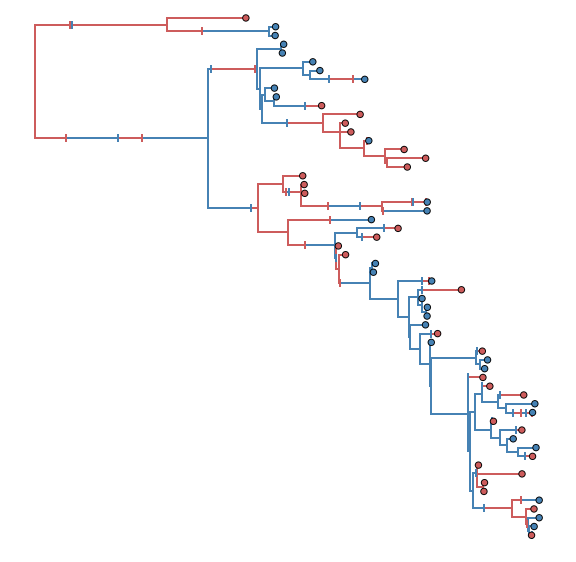

In [13]:
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
from scipy.special import binom

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22


## this is an example multitype tree from Tim Vaughan's website
mtt_string='(((((((((((((((((((((((1[&type="NewZealand"]:0.13447063630519973,7[&type="NewZealand"]:0.07967611630511295)73[&type="NewZealand"]:0.08929892793871219,(35[&type="HongKong"]:0.0983077536860848)139[&type="NewZealand"]:0.026831680557880322)76[&type="NewZealand"]:0.856126806165018,((((((9[&type="NewZealand"]:0.11601623057143884,(30[&type="NewZealand"]:0.33390325384627095,(32[&type="HongKong"]:0.13766841842148708)136[&type="NewZealand"]:0.13048140542469772)64[&type="NewZealand"]:0.2149896867252411)66[&type="NewZealand"]:0.13568329823904235,(38[&type="HongKong"]:0.11003967187298419)142[&type="NewZealand"]:0.30604341693752996)68[&type="NewZealand"]:0.17280660166770023,(31[&type="HongKong"]:0.01922423569874898)135[&type="NewZealand"]:0.02993942477935463)70[&type="NewZealand"]:0.29183308256846874,(((((((13[&type="NewZealand"]:0.013813882359079016)129[&type="HongKong"]:0.11994499382241533)130[&type="NewZealand"]:0.08719297614564103)131[&type="HongKong"]:0.14766781703709309)132[&type="NewZealand"]:0.12654847821710452,15[&type="NewZealand"]:0.5390037675813146)67[&type="NewZealand"]:0.15257756221856533,(34[&type="HongKong"]:0.45880454460840236)138[&type="NewZealand"]:0.021817885191554365)69[&type="NewZealand"]:0.31815148193398224,(36[&type="HongKong"]:0.15387977298196498)140[&type="NewZealand"]:0.0010585187518559191)72[&type="NewZealand"]:0.11756530131275666)77[&type="NewZealand"]:0.10379907279117573,(((((((14[&type="NewZealand"]:0.10046948691076452,(37[&type="HongKong"]:3.3546858288771575E-4)141[&type="NewZealand"]:0.0508189483277289)61[&type="NewZealand"]:0.009627603607619994,17[&type="NewZealand"]:0.2059875005181953)62[&type="NewZealand"]:0.03168724295753245)148[&type="HongKong"]:0.01037051166271774,48[&type="HongKong"]:0.14941511513860445)63[&type="HongKong"]:0.2647308018843468,(16[&type="NewZealand"]:0.3495737463164387)133[&type="HongKong"]:0.16320231070635355)65[&type="HongKong"]:0.5361745261033274)149[&type="NewZealand"]:0.19944323646963635,(((39[&type="HongKong"]:0.8454525733333191,(55[&type="HongKong"]:0.026979497089165472,56[&type="HongKong"]:0.03793840708916485)71[&type="HongKong"]:0.09518540624416305)74[&type="HongKong"]:0.0013922840170963457,50[&type="HongKong"]:0.019447597350417567)75[&type="HongKong"]:0.019156628921160213)150[&type="NewZealand"]:0.05636493332425041)78[&type="NewZealand"]:0.06489514624194137)79[&type="NewZealand"]:0.04176866566869086,(54[&type="HongKong"]:0.27670607551451565)145[&type="NewZealand"]:0.009858405991877817)80[&type="NewZealand"]:0.7056606589024674)81[&type="NewZealand"]:0.005746895932619012,2[&type="NewZealand"]:0.017150116341554167)82[&type="NewZealand"]:0.18774968336544928,(60[&type="HongKong"]:0.13259204705586614)147[&type="NewZealand"]:0.19285570265108287)85[&type="NewZealand"]:0.20719413522249308,3[&type="NewZealand"]:0.30250489492955035)87[&type="NewZealand"]:0.010849333826263852,(((12[&type="NewZealand"]:0.023833838054824863,25[&type="NewZealand"]:0.018354388054885984)83[&type="NewZealand"]:0.08076085264617028,22[&type="NewZealand"]:0.0032248307010180888)84[&type="NewZealand"]:0.07103232524165737,(33[&type="HongKong"]:0.7543990076042073)137[&type="NewZealand"]:0.0678033483384719)86[&type="NewZealand"]:0.1733436528131742)88[&type="NewZealand"]:0.20653575547289993,((6[&type="NewZealand"]:0.05020673950861232)124[&type="HongKong"]:0.13436214138630875)125[&type="NewZealand"]:0.45312932333370837)89[&type="NewZealand"]:0.5376805088053045,(24[&type="NewZealand"]:0.018559534865435712,29[&type="NewZealand"]:0.05691569486535686)93[&type="NewZealand"]:0.04996986816858229)94[&type="NewZealand"]:0.5572269633202391)153[&type="HongKong"]:0.029706148286283263,53[&type="HongKong"]:0.12669538464053476)99[&type="HongKong"]:0.056990274747895864,49[&type="HongKong"]:0.04669935938844105)100[&type="HongKong"]:0.004949423240362627)154[&type="NewZealand"]:0.01647952434667488,((47[&type="HongKong"]:0.2851458906695372)144[&type="NewZealand"]:0.09617306602207343,(57[&type="HongKong"]:0.2763969163181357)146[&type="NewZealand"]:0.510401500373399)96[&type="NewZealand"]:0.4155764702837974)101[&type="NewZealand"]:0.5598836566197125)155[&type="HongKong"]:0.321717045259728,(10[&type="NewZealand"]:0.7817385255174321)128[&type="HongKong"]:0.7953877433374394)107[&type="HongKong"]:0.5692515437316565,(((((((((4[&type="NewZealand"]:0.8384238254762248)120[&type="HongKong"]:0.026262369435535504,(((5[&type="NewZealand"]:0.016984078204738573)121[&type="HongKong"]:0.2506305935325863)122[&type="NewZealand"]:0.02306652809735743)123[&type="HongKong"]:0.5767447150769867)92[&type="HongKong"]:0.41224343893704374)151[&type="NewZealand"]:0.5969337985139167)152[&type="HongKong"]:0.5112656768868922,43[&type="HongKong"]:0.06184143924948593)105[&type="HongKong"]:0.0012558459635760855,42[&type="HongKong"]:0.05213837521306264)106[&type="HongKong"]:0.2416321233860046)157[&type="NewZealand"]:0.0559632636978753)158[&type="HongKong"]:0.057197297130238134,40[&type="HongKong"]:0.3795337994271373)108[&type="HongKong"]:0.462734423159338)115[&type="HongKong"]:0.1426839664350288)160[&type="NewZealand"]:0.8045924247799565,((((((((8[&type="NewZealand"]:0.22857168575889375)126[&type="HongKong"]:0.4540046092827814)127[&type="NewZealand"]:0.3585247420325284,19[&type="NewZealand"]:0.18904624707419249)103[&type="NewZealand"]:0.12484866994579669,28[&type="NewZealand"]:0.17964833701990823)104[&type="NewZealand"]:0.8299071635893247,((20[&type="NewZealand"]:0.17693639695029084,(21[&type="NewZealand"]:0.03675764504384116,(46[&type="HongKong"]:0.31376198590151816)143[&type="NewZealand"]:0.5832696291423032)110[&type="NewZealand"]:0.1757951919064622)112[&type="NewZealand"]:0.05710201414821903,((((((27[&type="NewZealand"]:0.03934777475949769)134[&type="HongKong"]:0.05927416022821852,((41[&type="HongKong"]:0.38110756637001275,51[&type="HongKong"]:0.7290527763700472)90[&type="HongKong"]:0.03595445531424568,59[&type="HongKong"]:0.3567880516842328)91[&type="HongKong"]:0.4130667633034175)95[&type="HongKong"]:0.45011463011820707,58[&type="HongKong"]:0.209010535105858)97[&type="HongKong"]:0.007118726095613592,52[&type="HongKong"]:0.10927995120155565)98[&type="HongKong"]:0.3126751125853895,45[&type="HongKong"]:0.7041468437868934)102[&type="HongKong"]:0.6886138552602752)156[&type="NewZealand"]:0.4686749720512937)113[&type="NewZealand"]:0.046749969510793576)114[&type="NewZealand"]:0.05515434149997489,(18[&type="NewZealand"]:0.030065855424983745,26[&type="NewZealand"]:0.05472339542489113)109[&type="NewZealand"]:0.45656179668419217)116[&type="NewZealand"]:0.0327191530296389)161[&type="HongKong"]:0.8272008570162335)162[&type="NewZealand"]:0.056695581646456716)117[&type="NewZealand"]:1.2570144258380544)163[&type="HongKong"]:0.4633814174179758)164[&type="NewZealand"]:0.9920728112746833)165[&type="HongKong"]:0.5900920387627338,(((((11[&type="NewZealand"]:0.11468604341949895,23[&type="NewZealand"]:0.12290522341946808)111[&type="NewZealand"]:1.2766650698063087)159[&type="HongKong"]:0.6712615899471537,44[&type="HongKong"]:1.506448323173034)118[&type="HongKong"]:1.8005558093266387)166[&type="NewZealand"]:0.0361141517744521)167[&type="HongKong"]:0.6695349728209106)119[&type="HongKong"]:0.0;'

mtt=bt.tree()
bt.make_tree(mtt_string,mtt)
mtt.treeStats()
mtt.sortBranches()

fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

branchWidth=2 ## default branch width

for k in mtt.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
    xp=k.parent.x ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    c=['indianred' if k.traits['type']=='HongKong' else 'steelblue'][0] ## can be discrete too
    
    if k.branchType=='leaf': ## if leaf...
        s=30 ## tip size can be fixed
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    elif k.branchType=='node': ## if node...
        if len(k.children)==1:
            ax.scatter(x,y,facecolor=c,s=50,edgecolor='none',zorder=10,lw=2,marker='|') ## mark every node in the tree to highlight that it's a multitype tree
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
ax.set_ylim(-1,mtt.ySpan+1)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

## Collapsing clades

baltic allows subtrees to be collapsed. When given a node object the collapseSubtree function will replace that node and any of its descendants with a clade object. These pose as tips, but contain attributes that allow the clade object to be plotted in a way that can represent how many tips were present in the collapsed clade or when the most recent tip of the collapsed subtree existed.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


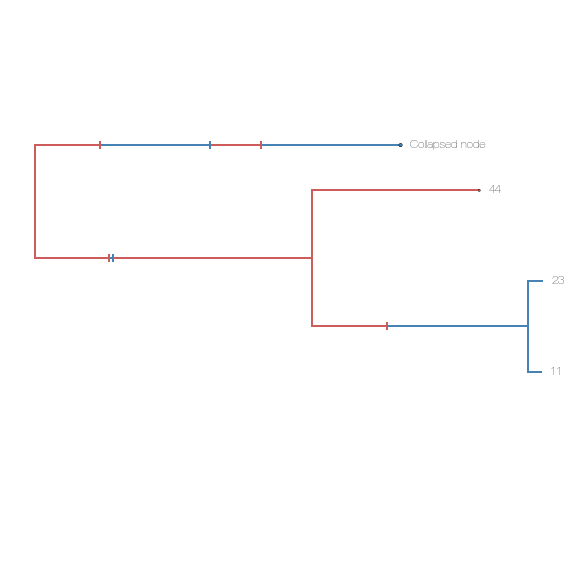

In [14]:
fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

branchWidth=2 ## default branch width

ancestor=mtt.commonAncestor(['37','46'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node',widthFunction=lambda x:1) ## the width function transforms the number of descendant tips that the node had into an amount of vertical space that the clade will receive in the plotted tree
mtt.sortBranches()

for k in mtt.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
    xp=k.parent.x ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    c=['indianred' if k.traits['type']=='HongKong' else 'steelblue'][0] ## can be discrete too
    
    if k.branchType=='leaf': ## if leaf...
        s=30 ## tip size can be fixed
        s=30-30*k.height/mtt.treeHeight
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        ax.text(x+30/365.0,y,'%s'%(k.numName),ha='left',va='center',size=12)
    elif k.branchType=='node': ## if node...
        ax.scatter(x,y,facecolor=c,s=50,edgecolor='none',zorder=10,lw=2,marker='|') ## mark every node in the tree to highlight that it's a multitype tree
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
ax.set_ylim(-1,mtt.ySpan+1)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

7.65374914709


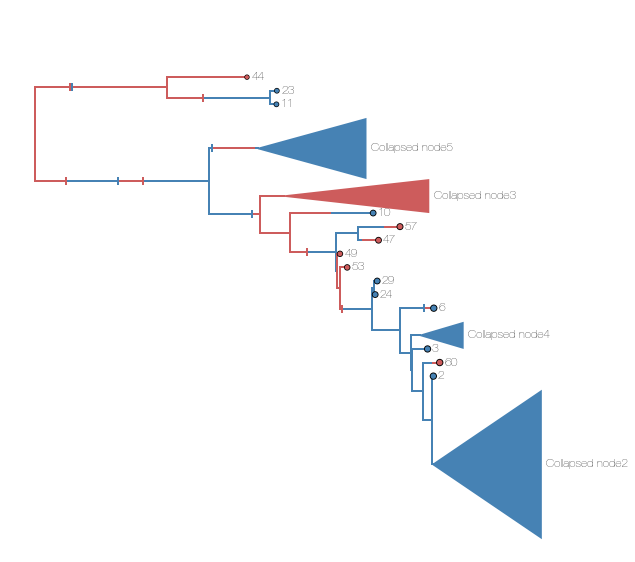

In [15]:
branchWidth=2 ## default branch width

from matplotlib.patches import Polygon

mtt.uncollapseSubtree() ## reset tree by uncollapsing clades

ancestor=mtt.commonAncestor(['41','45'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node',widthFunction=lambda x:x/2.0)
ancestor=mtt.commonAncestor(['35','37'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node2',widthFunction=lambda x:x/2.0)
ancestor=mtt.commonAncestor(['40','4'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node3',widthFunction=lambda x:x/2.0)
ancestor=mtt.commonAncestor(['25','33'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node4',widthFunction=lambda x:x/2.0)
ancestor=mtt.commonAncestor(['46','26'],numName=True) ## identify common ancestor node of two (or more) tips
mtt.collapseSubtree(ancestor,'Collapsed node5',widthFunction=lambda x:x/2.0)

# mtt.uncollapse()
mtt.traverse_tree()
mtt.sortBranches()

print mtt.treeHeight

fig,ax = plt.subplots(figsize=(10,10),facecolor='w')

for k in mtt.Objects: ## iterate over objects in tree
    x=k.x ## or from x position determined earlier
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
    xp=k.parent.x ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    c=['indianred' if k.traits['type']=='HongKong' else 'steelblue'][0] ## can be discrete too
    
    if k.branchType=='leaf': ## if leaf...
        #s=30 ## tip size can be fixed
        s=30*k.height/mtt.treeHeight
        
        if isinstance(k,bt.leaf): ## if branch is a leaf object
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.text(x+30/365.0,y,'%s'%(k.numName),ha='left',va='center',size=12)
        else: ## if not - it's actually a clade object
            clade=plt.Polygon(([x,y-0.001*len(mtt.Objects)],[x,y+0.001*len(mtt.Objects)],[k.lastHeight,y+k.width/2.0],[k.lastHeight,y-k.width/2.0]),facecolor=c,edgecolor='none',zorder=12) ## define a triangle polygon
            ax.add_patch(clade)
            ax.text(k.lastHeight+30/365.0,y,'%s'%(k.numName),ha='left',va='center',size=12)
        
        
    elif k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
        
        offspring=[w for w in k.children if w.branchType=='node']
        if len(offspring)==1:
            ax.scatter(x,y,facecolor=c,s=50,edgecolor='none',zorder=10,lw=2,marker='|')
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
    
ax.set_ylim(-1,mtt.ySpan+5)
plt.show()

## Clade frequencies
-----------------
Richard Neher (at Max Planck) has written a script called [``frequencies.py``](https://github.com/neherlab/nextstrain_base/blob/master/frequencies.py) to calculate clade frequencies over time. The next few cells show how clade frequencies can be incorporated into baltic via Biopython's phylogenetics parts and plotted.

In [16]:
import frequencies
from Bio import Phylo
from cStringIO import StringIO

ll=bt.loadNexus('/Users/evogytis/Documents/fluB/data/mcc trees/InfB_NPt_ALLs1.mcc.tre',tip_regex="\_([0-9]+)\-([0-9]+)\-([0-9]+)$") ## load tree

tips=[k.name for k in ll.Objects if k.branchType=='leaf'] ## get tip names
tipDates=[k.split('_')[-1] for k in tips] ## isolate collection date from tip name
dates=[bt.decimalDate(k,variable=True) for k in tipDates] ## convert dates into decimal dates

tr = Phylo.read(StringIO(ll.toString()), "newick") ## create a Bio.Phylo tree from the baltic tree

for k in ll.Objects:
    if k.length<0.0:
        k.length=0.0 ## convert negative branch lengths to 0.0

for n,nd in enumerate(tr.get_terminals()):
    nd.numdate = bt.decimalDate(nd.name.split('_')[-1],variable=True) ## assign collection date to Bio.Phylo tips

pivots = np.array(frequencies.make_pivots(200,np.array(dates))) ## create time grid for clade frequencies
bfq=frequencies.tree_frequencies(tr,min_clades=10,node_filter=None,pivots=pivots) ## create a frequencies object


Tree height: 29.430115
Tree length: 451.887106

Tree is strictly bifurcating = True

Tree is multitype = True

Tree has annotations = True

Numbers of objects in tree: 903 (452 nodes and 451 leaves)



In [17]:
bfq.estimate_clade_frequencies() ## estimate clade frequencies

24 ...
optimizing with 77 pivots
done
26 ...
optimizing with 9 pivots
done
30 ...
optimizing with 50 pivots
done
42 ...
optimizing with 50 pivots
done
48 ...
optimizing with 42 pivots
done
50 ...
optimizing with 9 pivots
done
56 ...
optimizing with 44 pivots
done
60 ...
optimizing with 36 pivots
done
62 ...
optimizing with 9 pivots
done
296 ...
optimizing with 120 pivots
done
85 ...
optimizing with 43 pivots
done
87 ...
optimizing with 33 pivots
done
95 ...
optimizing with 49 pivots
done
97 ...
optimizing with 33 pivots
done
99 ...
optimizing with 43 pivots
done
101 ...
optimizing with 33 pivots
done
103 ...
optimizing with 33 pivots
done
109 ...
optimizing with 11 pivots
done
125 ...
optimizing with 15 pivots
done
129 ...
optimizing with 15 pivots
done
157 ...
optimizing with 43 pivots
done
134 ...
optimizing with 63 pivots
done
136 ...
optimizing with 51 pivots
done
159 ...
optimizing with 15 pivots
done
161 ...
optimizing with 8 pivots
done
165 ...
optimizing with 30 pivots
done
169

In [18]:
for n,nd in enumerate(ll.traverse_tree(include_all=True)[1:]): ## frequencies are estimated in traversal order
    if nd.branchType=='node':
        nd.traits['cf']=bfq.frequencies[n] ## assign frequency vector to node

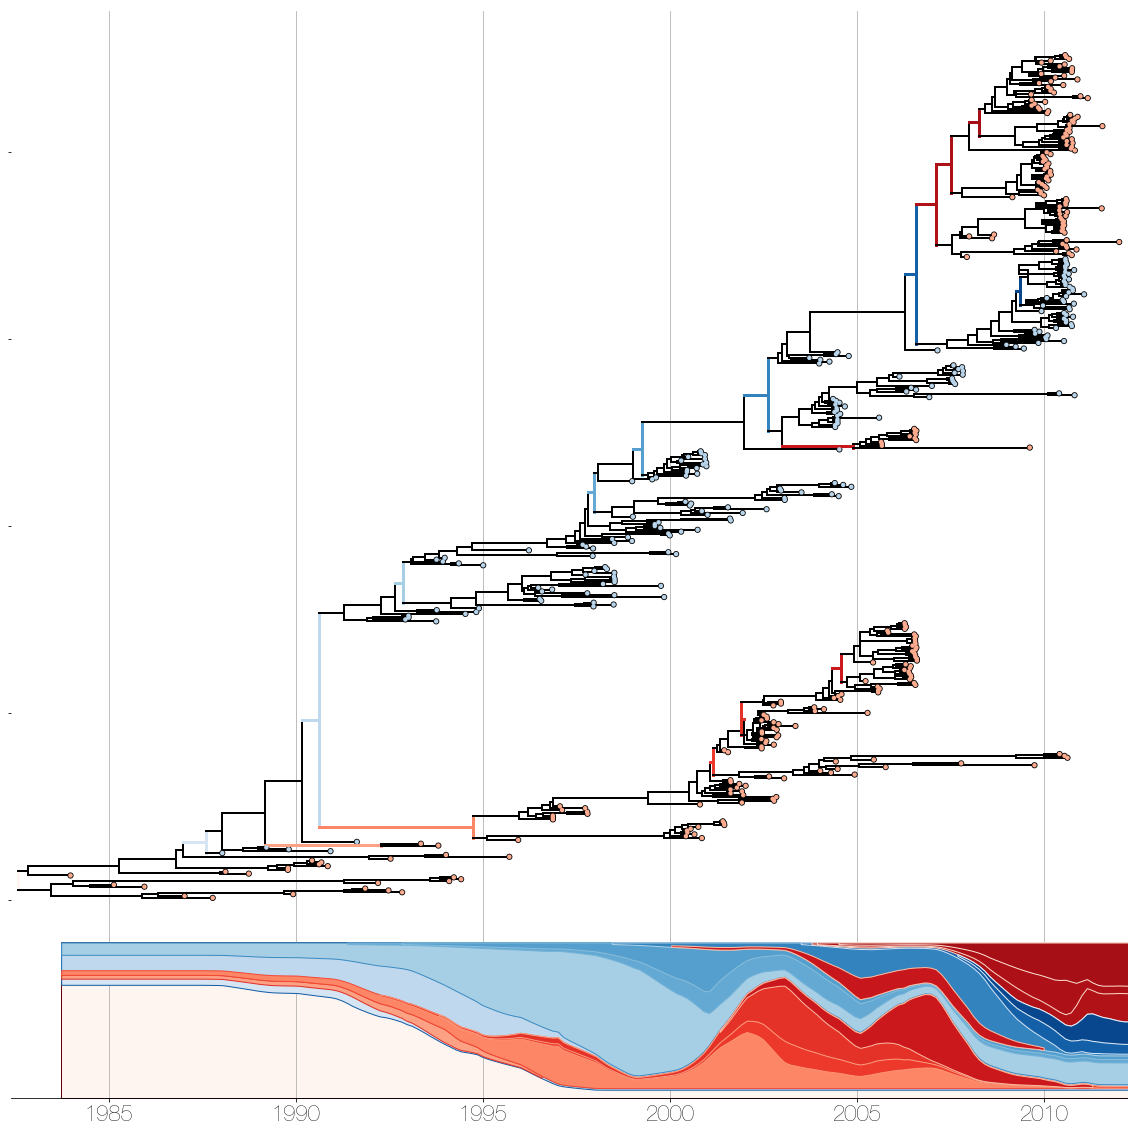

In [19]:
import matplotlib.gridspec as gridspec
fig = plt.subplots(figsize=(20,20),facecolor='w')

gs = gridspec.GridSpec(2, 1,height_ratios=[6,1],hspace=0.0)
ax2 = plt.subplot(gs[0])
ax= plt.subplot(gs[1],sharex=ax2)

condition=lambda x:(len([1 for k in x.children if k.branchType=='node' and len(k.leaves)>=12])==2)

ll.sortBranches(descending=False)
traitName='PB2'
def plot_subclade(ax, cfreq, clade, pivots):
    """ Iteratively plot clade frequencies.
        Code written by Richard Neher.
    """
    
    if clade.traits.has_key(traitName):
        if clade.traits[traitName]=='V':
            cmap=mpl.cm.Reds
        else:
            cmap=mpl.cm.Blues
    else:
        cmap=mpl.cm.Purples_r
    
    if clade.branchType=='node':
        if condition(clade) or clade.traits[traitName]!=clade.parent.traits[traitName]:
            fr=clade.height/ll.treeHeight
            colour=cmap(fr)
            ec=cmap(1-fr)
            cfs=clade.traits['cf']
            idx0,idx1=None,None
            for i,x in enumerate(cfs):
                if x>0.01 and idx0==None:
                    idx0=i
                if idx0!=None and x>0.01:
                    idx1=i
                    
            if idx0==None:
                idx0=0
            if idx1==None:
                idx1=len(cfs)
            
            inc=clade.traits['cf'][idx0:idx1]
            p=pivots[idx0:idx1]
            c=cfreq[idx0:idx1]
            
            ax.fill_between(p, c, c+inc,
                        facecolor=colour,
                        edgecolor=ec,alpha=1,
                        linestyle='-',zorder=int(clade.height*100000))
    
    tmp_cfreq = np.copy(cfreq)
    for c in clade.children:
        if c.branchType=='node':
            tmp_cfreq = plot_subclade(ax, tmp_cfreq, c, pivots)

    return cfreq+clade.traits['cf']


cfreq = np.zeros_like(pivots) ## empty list to hold trajectories
plot_subclade(ax, cfreq, ll.root.children[-1], pivots)

for k in ll.Objects:
    
    traitName='PB2'
    if k.traits.has_key(traitName):
        if k.traits[traitName]=='V':
            cmap=mpl.cm.Reds
        else:
            cmap=mpl.cm.Blues
    else:
        cmap=mpl.cm.Purples_r
    
    colour='k'
    lw=2
    x=k.absoluteTime ## or from x position determined earlier
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if k.branchType=='node':
        ly=k.children[0].y
        ry=k.children[-1].y
        if condition(k) or k.traits[traitName]!=k.parent.traits[traitName]:
#             fr=k.y/ll.ySpan
            fr=k.height/ll.treeHeight
            colour=cmap(fr)
            lw=3
        ax2.plot([x,x],[ly,ry],color=colour,lw=lw,zorder=3)
    else:
        ax2.scatter(x,y,s=20,facecolor=cmap(0.3),edgecolor='none',zorder=4)
        ax2.scatter(x,y,s=20*1.9,facecolor='k',edgecolor='none',zorder=3)
    ax2.plot([xp,x],[y,y],color=colour,lw=lw,zorder=3)


ats=[k.absoluteTime for k in ll.Objects]
fr=0.2
ax.set_xlim(min(pivots),max(pivots))
ax2.set_xlim(min(ats)-fr,max(ats)+fr)
ax.set_ylim(0,1)
ax.invert_yaxis()

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(False) ## no axes
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.grid(axis='x')
ax2.grid(axis='x')
plt.show()